In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [ ]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [ ]:
x_train,x_valid = normalize_to(x_train,x_valid)

In [ ]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [ ]:
nh,bs = 50,512
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs))

In [ ]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [ ]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [ ]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,16, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(16,data.c)
    )

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(AvgStatsCallback(accuracy))

In [ ]:
%time run.fit(1, learn)

train: [2.0109884375, tensor(0.2988)]
valid: [1.6550830078125, tensor(0.4445)]
Wall time: 20 s


## CUDA

In [ ]:
#export
class CudaCallback(Callback):
    def begin_fit(self, run): run.model.cuda()
    def begin_batch(self, run): run.xb,run.yb = run.xb.cuda(),run.yb.cuda()

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner([AvgStatsCallback(accuracy), CudaCallback()])

In [ ]:
%time run.fit(3, learn)

train: [0.504483671875, tensor(0.8472, device='cuda:0')]
valid: [0.3542950439453125, tensor(0.8977, device='cuda:0')]
train: [0.4078487109375, tensor(0.8781, device='cuda:0')]
valid: [0.332152490234375, tensor(0.8992, device='cuda:0')]
train: [0.3415240625, tensor(0.8998, device='cuda:0')]
valid: [0.302246923828125, tensor(0.9102, device='cuda:0')]
Wall time: 9.23 s


## Refactor model

In [ ]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [ ]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self, run): run.xb = self.tfm(run.xb)

def resize_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

This model can now work on any size input:

In [ ]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==1 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [ ]:
def get_runner(model, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner([AvgStatsCallback([accuracy]), CudaCallback(),
        BatchTransformXCallback(resize_tfm(1,28,28))] + listify(cbs))

In [ ]:
nfs = [8,16,32,32]

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [ ]:
run.fit(3, learn)

train: [2.1661809375, tensor(0.2213, device='cuda:0')]
valid: [0.96212216796875, tensor(0.6964, device='cuda:0')]
train: [0.61833390625, tensor(0.8076, device='cuda:0')]
valid: [0.241939404296875, tensor(0.9291, device='cuda:0')]
train: [0.21242623046875, tensor(0.9346, device='cuda:0')]
valid: [0.1720182373046875, tensor(0.9475, device='cuda:0')]


## Hooks

### Manual insertion

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean())
            self.act_stds [i].append(x.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [ ]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, lr=0.5)

In [ ]:
run.fit(2, learn)

train: [2.264268125, tensor(0.1544, device='cuda:0')]
valid: [2.256278125, tensor(0.1958, device='cuda:0')]
train: [1.04489671875, tensor(0.6784, device='cuda:0')]
valid: [0.2587965576171875, tensor(0.9260, device='cuda:0')]


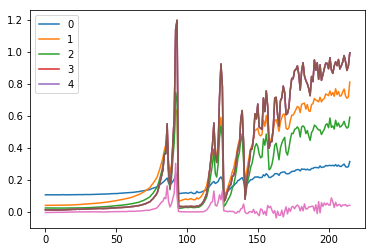

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

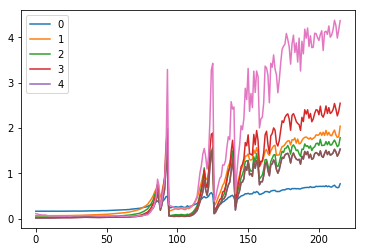

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

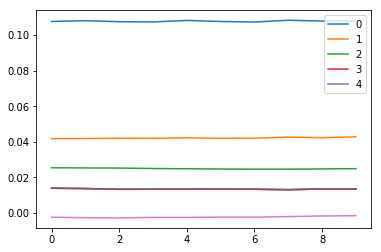

In [ ]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

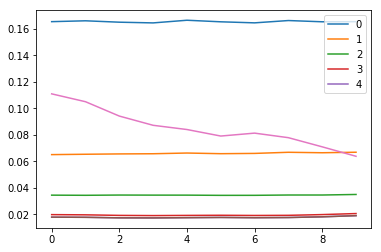

In [ ]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [ ]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.means = []
        self.stds  = []
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
def append_stats(hook, mod, inp, outp):
    hook.means.append(outp.mean())
    hook.stds .append(outp.std())

In [ ]:
hooks = [Hook(l, append_stats) for l in model]

In [ ]:
run.fit(1, learn)

train: [2.27114125, tensor(0.1541, device='cuda:0')]
valid: [2.193592578125, tensor(0.1543, device='cuda:0')]


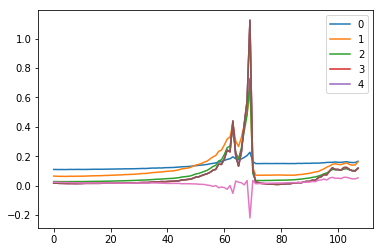

In [ ]:
for h in hooks:
    plt.plot(h.means)
    h.remove()
plt.legend(range(5));

### A Hooks class

In [ ]:
#export
from torch.nn import init

In [ ]:
class Hooks():
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __getitem__(self,i): return self.hooks[i]
    def __len__(self): return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self.hooks: h.remove()

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [ ]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

train: [1.741965625, tensor(0.4123, device='cuda:0')]
valid: [0.392157421875, tensor(0.8833, device='cuda:0')]


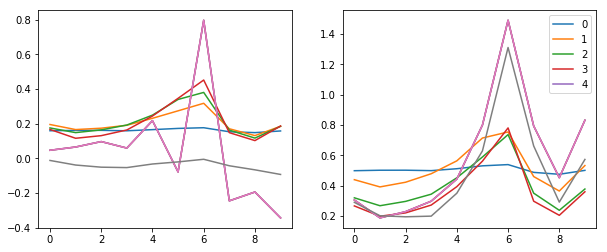

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    plt.legend(range(5));

## Generalized ReLU

In [ ]:
#export
def get_cnn_layers(data, nfs, **kwargs):
    nfs = [1] + nfs + [data.c]
    return [conv2d(nfs[i], nfs[i+1], **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs, **kwargs): return nn.Sequential(*get_cnn_layers(data, nfs, **kwargs))

def conv2d(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [ ]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.15, maxv=6.))

for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

learn,run = get_runner(model, lr=0.1)

train: [0.28238353515625, tensor(0.9176, device='cuda:0')]
valid: [0.2247010986328125, tensor(0.9322, device='cuda:0')]


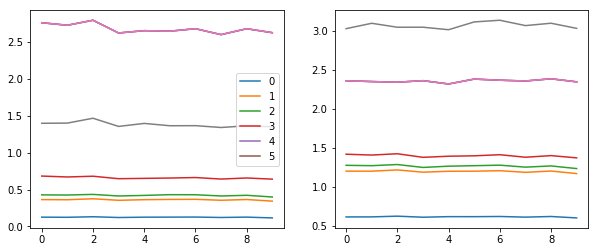

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));

In [ ]:
def get_learn_run(nfs):
    model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.15, maxv=6.))
    for l in model:
        if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)
    return get_runner(model, lr=1.)

In [ ]:
learn,run = get_learn_run(nfs)

In [ ]:
run.fit(3, learn)

train: [0.850074296875, tensor(0.7118, device='cuda:0')]
valid: [0.16146248779296876, tensor(0.9561, device='cuda:0')]
train: [0.13718111328125, tensor(0.9590, device='cuda:0')]
valid: [0.1147913818359375, tensor(0.9686, device='cuda:0')]
train: [0.097295693359375, tensor(0.9710, device='cuda:0')]
valid: [0.0853964599609375, tensor(0.9733, device='cuda:0')]


## Batchnorm

### Custom

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.9, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones (1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
        self.means *= self.mom
        self.means += (1-self.mom)*m
        self.vars  *= self.mom
        self.vars  += (1-self.mom)*v

    def forward(self, x):
        if self.training: self.update_stats(x)
        x = (x-self.means).div((self.vars+self.eps).sqrt())
        return x.mul(self.mults).add(self.adds)

In [ ]:
torch.lerp

In [ ]:
torch.lerp(tensor(1.), tensor(2.), 0.9)

tensor(1.9000)

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # Our mom is (1-pytorch_mom), since pytorch is weird
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones (1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
#         self.means.mul(self.mom).add_((1-self.mom)*m)
#         self.vars.mul (self.mom).add_((1-self.mom)*v)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        x = (x-self.means).div_((self.vars+self.eps).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
def conv2d(ni, nf, ks=3, stride=2, act=True, bn=True):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn)]
    if act: layers.append(nn.ReLU())
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.6)

In [ ]:
%time run.fit(3, learn)

train: [27.3756025, tensor(0.1112, device='cuda:0')]
valid: [8.161359375, tensor(0.1503, device='cuda:0')]
train: [11.04904375, tensor(0.1379, device='cuda:0')]
valid: [10.52715, tensor(0.1050, device='cuda:0')]
train: [6.160721875, tensor(0.1251, device='cuda:0')]
valid: [3.87364921875, tensor(0.1023, device='cuda:0')]
Wall time: 7.29 s


### jit

In [ ]:
#export
from torch.jit import ScriptModule, script_method, script
from typing import *

In [ ]:
class BatchNorm(ScriptModule):
    __constants__ = ['mom', 'eps']
    def __init__(self, nf, mom=0.9, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones (1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    @script_method
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
#         self.means *= self.mom
#         self.means *= self.mom
#         self.means += (1-self.mom)*m
#         self.vars  *= self.mom
#         self.vars  += (1-self.mom)*v

    @script_method
    def forward(self, x):
        if self.training: self.update_stats(x)
        x = (x-self.means).div((self.vars+self.eps).sqrt())
        return x.mul(self.mults).add(self.adds)

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.6)

In [ ]:
%time run.fit(3, learn)

train: [2.282228125, tensor(0.1271, device='cuda:0')]
valid: [2.3197984375, tensor(0.0594, device='cuda:0')]
train: [1.64021765625, tensor(0.3824, device='cuda:0')]
valid: [1.006786328125, tensor(0.7438, device='cuda:0')]
train: [0.408379296875, tensor(0.8730, device='cuda:0')]
valid: [0.17128485107421876, tensor(0.9509, device='cuda:0')]
Wall time: 9.97 s


### Builtin batchnorm

In [ ]:
#export
def conv2d(ni, nf, ks=3, stride=2, act=True, bn=True):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn)]
    if act: layers.append(nn.ReLU())
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.4, cbs=[CudaCallback(), BatchTransformXCallback(resize_tfm(1,28,28))])

In [ ]:
%time run.fit(6, learn)

train: [0.049129072265625, tensor(0.9879, device='cuda:0')]
valid: [0.08254159545898437, tensor(0.9761, device='cuda:0')]
train: [0.0455973291015625, tensor(0.9886, device='cuda:0')]
valid: [0.06360925903320312, tensor(0.9835, device='cuda:0')]
train: [0.04050991943359375, tensor(0.9893, device='cuda:0')]
valid: [0.06290653686523437, tensor(0.9829, device='cuda:0')]
train: [0.03743682373046875, tensor(0.9906, device='cuda:0')]
valid: [0.060035589599609376, tensor(0.9838, device='cuda:0')]
train: [0.0341969921875, tensor(0.9914, device='cuda:0')]
valid: [0.057718115234375, tensor(0.9842, device='cuda:0')]
train: [0.031028759765625, tensor(0.9922, device='cuda:0')]
valid: [0.06487869262695313, tensor(0.9823, device='cuda:0')]
CPU times: user 5 s, sys: 68 ms, total: 5.07 s
Wall time: 5.09 s


### With scheduler

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_lin(0.2, 0.8), sched_lin(0.8, 0.2)]) 

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.4, cbs=[Recorder(), CudaCallback(),
    BatchTransformXCallback(resize_tfm(1,28,28)), ParamScheduler('lr', sched)])

In [ ]:
run.fit(3, learn)

train: [0.682678984375, tensor(0.8528, device='cuda:0')]
valid: [0.3456614501953125, tensor(0.8981, device='cuda:0')]
train: [0.157797470703125, tensor(0.9604, device='cuda:0')]
valid: [0.164066064453125, tensor(0.9537, device='cuda:0')]
train: [0.08712751953125, tensor(0.9780, device='cuda:0')]
valid: [0.07777939453125, tensor(0.9789, device='cuda:0')]


## More layers

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_lin(0.2, 0.8), sched_lin(0.8, 0.01)]) 

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.4, cbs=[Recorder(), CudaCallback(),
    BatchTransformXCallback(resize_tfm(1,28,28)), ParamScheduler('lr', sched)])

In [ ]:
run.fit(8, learn)

train: [0.498337421875, tensor(0.9000, device='cuda:0')]
valid: [0.2021446044921875, tensor(0.9479, device='cuda:0')]
train: [0.122512021484375, tensor(0.9708, device='cuda:0')]
valid: [0.127957421875, tensor(0.9635, device='cuda:0')]
train: [0.082052060546875, tensor(0.9785, device='cuda:0')]
valid: [0.07273471069335938, tensor(0.9799, device='cuda:0')]
train: [0.0615674462890625, tensor(0.9834, device='cuda:0')]
valid: [0.09457974853515624, tensor(0.9709, device='cuda:0')]
train: [0.042147236328125, tensor(0.9881, device='cuda:0')]
valid: [0.07584328002929687, tensor(0.9770, device='cuda:0')]
train: [0.025492666015625, tensor(0.9933, device='cuda:0')]
valid: [0.04980409545898438, tensor(0.9852, device='cuda:0')]
train: [0.0147454931640625, tensor(0.9970, device='cuda:0')]
valid: [0.04962567443847656, tensor(0.9873, device='cuda:0')]
train: [0.009472476806640625, tensor(0.9987, device='cuda:0')]
valid: [0.04268844909667969, tensor(0.9887, device='cuda:0')]


## Export

In [ ]:
!./notebook2script.py 06_cuda_cnn_bn.ipynb

Converted 06_cuda_cnn_bn.ipynb to nb_06.py
